## Imports

In [20]:
import cv2
import numpy as np
import math
from collections import defaultdict
from PIL import Image,ImageDraw
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import face_recognition  # install from https://github.com/ageitgey/face_recognition

## 导入图片

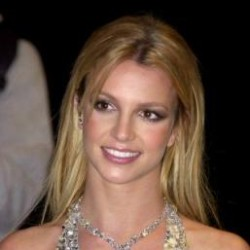

In [21]:
img_name = './img/Britney_Spears_0004.jpg'
# img_name = './img/Britney_Spears_0004.jpg'

image_array = cv2.imread(img_name)
image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
Image.fromarray(image_array)

## 人脸检测
使用[face_recognition api](https://github.com/ageitgey/face_recognition)检测人脸的关键点， model="large"时返回68个关键点， model="small"时返回5个关键点。

In [22]:

face_landmarks_list = face_recognition.face_landmarks(image_array, model="small")
face_landmarks_dict = face_landmarks_list[0]
print(face_landmarks_dict, end=" ")

{'nose_tip': [(121, 142)], 'left_eye': [(97, 105), (114, 109)], 'right_eye': [(157, 117), (139, 114)]} 

定义人脸关键点可视化函数

In [23]:
def visualize_landmark(image_array, landmarks):
    """ plot landmarks on image
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return: plots of images with landmarks on
    """
    origin_img = Image.fromarray(image_array)
    draw = ImageDraw.Draw(origin_img)
    for facial_feature in landmarks.keys():
        draw.point(landmarks[facial_feature])
    imshow(origin_img)

可视化人脸关键点

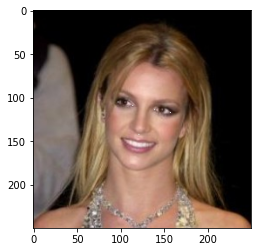

In [24]:
visualize_landmark(image_array=image_array,landmarks=face_landmarks_dict)
plt.show()

## 人脸对齐
### 人脸旋转对齐
人脸对齐思路：
* 分别计算左、右眼中心坐标
* 计算左右眼中心坐标与水平方向的夹角θ
* 计算左右两眼整体中心坐标
* 以左右两眼整体中心坐标为基点，将图片array逆时针旋转θ    


以下定义了人脸对齐函数

In [25]:
def align_face(image_array, landmarks):
    """ align faces according to eyes position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    rotated_img:  numpy array of aligned image
    eye_center: tuple of coordinates for eye center
    angle: degrees of rotation
    """
    # get list landmarks of left and right eye
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    # calculate the mean point of landmarks of left and right eye
    left_eye_center = np.mean(left_eye, axis=0).astype("int")
    right_eye_center = np.mean(right_eye, axis=0).astype("int")
    # compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    # compute angle between the line of 2 centeroids and the horizontal line
    angle = math.atan2(dy, dx) * 180. / math.pi
    # calculate the center of 2 eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                  (left_eye_center[1] + right_eye_center[1]) // 2)
    # at the eye_center, rotate the image by the angle
    rotate_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1)
    rotated_img = cv2.warpAffine(image_array, rotate_matrix, (image_array.shape[0], image_array.shape[1]))
    return rotated_img, eye_center, angle

根据眼睛位置旋转整个图片，达到人脸对齐的目的。下图可以看出，旋转后图片（右图）中的人脸一对齐，双眼在水平方向上。align_face函数输出的eye_center, angle会在章节4.2张使用到。

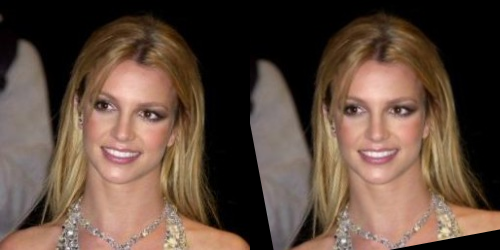

In [26]:
aligned_face, eye_center, angle = align_face(image_array=image_array, landmarks=face_landmarks_dict)
Image.fromarray(np.hstack((image_array,aligned_face)))

### 人脸关键点旋转
图片旋转后，图中的landmark坐标也要相应旋转，这样landmark才能匹配旋转后的图片。landmark旋转前的效果如下：

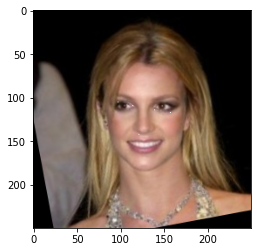

In [27]:
visualize_landmark(image_array=aligned_face,landmarks=face_landmarks_dict)
plt.show()

定义旋转图片中坐标的函数，由于图片和普通坐标系的原点不同，两者坐标点的旋转方式略有出入，图片坐标旋转涉及y坐标在图片坐标系和普通坐标系之间的变换。

In [28]:
def rotate(origin, point, angle, row):
    """ rotate coordinates in image coordinate system
    :param origin: tuple of coordinates,the rotation center
    :param point: tuple of coordinates, points to rotate
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated coordinates of point
    """
    x1, y1 = point
    x2, y2 = origin
    y1 = row - y1
    y2 = row - y2
    angle = math.radians(angle)
    x = x2 + math.cos(angle) * (x1 - x2) - math.sin(angle) * (y1 - y2)
    y = y2 + math.sin(angle) * (x1 - x2) + math.cos(angle) * (y1 - y2)
    y = row - y
    return int(x), int(y)

定义旋转图片中landmark的函数，以人脸双眼中心为基点，将每个人脸关键点逆时针旋转θ，该θ角度是人脸对齐的旋转角度。

In [29]:
def rotate_landmarks(landmarks, eye_center, angle, row):
    """ rotate landmarks to fit the aligned face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param eye_center: tuple of coordinates for eye center
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated_landmarks with the same structure with landmarks, but different values
    """
    rotated_landmarks = defaultdict(list)
    for facial_feature in landmarks.keys():
        for landmark in landmarks[facial_feature]:
            rotated_landmark = rotate(origin=eye_center, point=landmark, angle=angle, row=row)
            rotated_landmarks[facial_feature].append(rotated_landmark)
    return rotated_landmarks

以下旋转所有人脸关键点，并可视化。

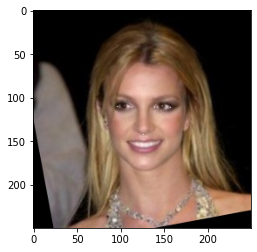

In [30]:
rotated_landmarks = rotate_landmarks(landmarks=face_landmarks_dict,
                                         eye_center=eye_center, angle=angle, row=image_array.shape[0])
visualize_landmark(image_array=aligned_face,landmarks=rotated_landmarks)
plt.show()

## 人脸裁剪
通常，人脸对齐后会根据landmark裁剪人脸到固定尺寸，再feed近卷积网络。此处裁剪的思路为：
* 垂直方向上分为三部分
    * 中部：两眼landmark中心到嘴巴landmark中心的像素距离，占垂直方向的35%
    * 底部：占垂直方向的35%
    * 顶部：占垂直方向的30%
* 水平方向以最靠左和最靠右的landmark的中点为裁剪后图片的中心点，crop区域w=h

定义裁剪函数

In [33]:
def corp_face(image_array, landmarks):
    """ crop face according to eye,mouth and chin position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    cropped_img: numpy array of cropped image
    """

    eye_landmark = np.concatenate([np.array(landmarks['left_eye']),
                                   np.array(landmarks['right_eye'])])
    eye_center = np.mean(eye_landmark, axis=0).astype("int")
    lip_landmark = np.concatenate([np.array(landmarks['top_lip']),
                                   np.array(landmarks['bottom_lip'])])
    lip_center = np.mean(lip_landmark, axis=0).astype("int")
    mid_part = lip_center[1] - eye_center[1]
    top = eye_center[1] - mid_part * 30 / 35
    bottom = lip_center[1] + mid_part

    w = h = bottom - top
    x_min = np.min(landmarks['chin'], axis=0)[0]
    x_max = np.max(landmarks['chin'], axis=0)[0]
    x_center = (x_max - x_min) / 2 + x_min
    left, right = (x_center - w / 2, x_center + w / 2)

    pil_img = Image.fromarray(image_array)
    left, top, right, bottom = [int(i) for i in [left, top, right, bottom]]
    cropped_img = pil_img.crop((left, top, right, bottom))
    cropped_img = np.array(cropped_img)
    return cropped_img,left, top


In [34]:
cropped_img,left, top= corp_face(image_array=aligned_face, landmarks=rotated_landmarks)
Image.fromarray(cropped_img)

IndexError: invalid index to scalar variable.